# Probabilistic Programming - 2
## Variational inference

In this notebook, we are exploring a more complex problem set using variational inference. We will look at how to specify a model and a variational inference procedure for a mixture model. 

### Preliminaries

- Goal 
  - Write a probabilistic program for a mixture model
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
    - Cheatsheets: how does Julia differ from Matlab / Python (https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).
    - Getting started with ForneyLab (https://biaslab.github.io/forneylab/docs/getting-started/).

## Mixture modeling

We will first generate a synthetic data set to play around. This will let us focus on the data-generating process and on the point that a good model should follow the data-generating process.

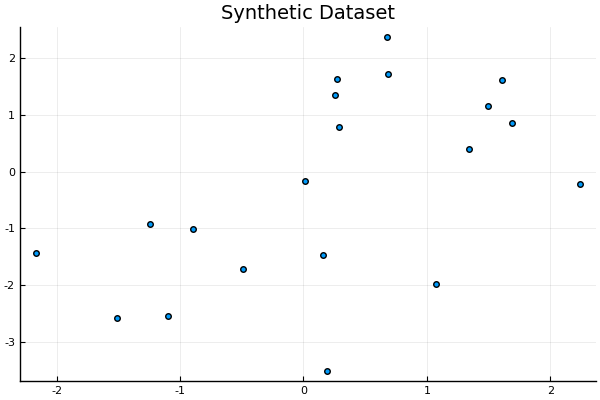

In [1]:
using Random
import Distributions: MvNormal, Normal, pdf
using Plots
pyplot()

# Set a random seed.
Random.seed!(3)

# Construct 10 data points for each cluster.
N = 10

# Means for each cluster, assuming each cluster is Gaussian distributed
μ1 = [-1, -1]
μ2 = [+1, +1]

# Concatenate means
μs = [μ1 μ2]

# Construct the data points.
X = mapreduce(c -> rand(MvNormal(μs[:, c], 1.), N), hcat, 1:2)'

# Visualization.
scatter(X[:,1], X[:,2], legend = false, title = "Synthetic Dataset")

### Variational inference

In [52]:
using ForneyLab

g = FactorGraph()

# Specify generative model
@RV _pi ~ Dirichlet([1.0, 1.0])
@RV m_1 ~ GaussianMeanVariance([0.0, 0.0], 100*[1. 0.; 0. 1.])
@RV w_1 ~ Wishart([1. 0.; 0. 1.], 2.)
@RV m_2 ~ GaussianMeanVariance([0.0, 0.0], 100*[1. 0.; 0. 1.])
@RV w_2 ~ Wishart([1. 0.; 0. 1.], 2.)

z = Vector{Variable}(undef, N)
y = Vector{Variable}(undef, N)
for i = 1:N
    @RV z[i] ~ Categorical(_pi)
    @RV y[i] ~ GaussianMixture(z[i], m_1, w_1, m_2, w_2)
    
    placeholder(y[i], :y, dims=(2,), index=i)
end

Now, you need to specify a distribution with which you will approximate the posterior distribution that you would normally obtain through exact Bayesian inference.

In [53]:
# Specify recognition factorization (mean-field)
q = RecognitionFactorization(_pi, m_1, w_1, m_2, w_2, z, ids=[:PI, :M1, :W1, :M2, :W2, :Z])

# Generate the algorithm
algo = variationalAlgorithm(q)
algo_F = freeEnergyAlgorithm(q);

# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algo_F))

freeEnergy (generic function with 1 method)

Now, we execute the algorithm

In [54]:
data = Dict(:y => X)

# Prepare recognition distributions
marginals = Dict(:_pi => ProbabilityDistribution(Dirichlet, a=[1.0, 1.0]),
                 :m_1 => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=[-1.0, -1.0], v=1e4*[1. 0.;0. 1.]),
                 :w_1 => ProbabilityDistribution(MatrixVariate, Wishart, v=[1. 0.;0. 1.], nu=2.),
                 :m_2 => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=[1.0, 1.0], v=1e4*[1. 0.;0. 1.]),
                 :w_2 => ProbabilityDistribution(MatrixVariate, Wishart, v=[1. 0.;0. 1.], nu=2.))
for i = 1:N
    marginals[:z_*i] = ProbabilityDistribution(Categorical, p=[1/2., 1/2.])
end

# Execute algorithm
num_iterations = 10
F = Float64[]
for i = 1:num_iterations
    stepZ!(data, marginals)
    stepPI!(data, marginals)
    stepM1!(data, marginals)
    stepW1!(data, marginals)
    stepM2!(data, marginals)
    stepW2!(data, marginals)
    
        
    # Store variational free energy for visualization
    push!(F, freeEnergy(data, marginals))
end

TypeError: TypeError: in keyword argument m, expected Array{T,1} where T, got Float64

In [48]:
println(algo)

begin

function stepZ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 20))

messages[1] = ruleVBCategoricalOut(nothing, marginals[:_pi])
messages[2] = ruleVBGaussianMixtureZBer(ProbabilityDistribution(Multivariate, PointMass, m=data[:y][9]), nothing, marginals[:m_1], marginals[:w_1], marginals[:m_2], marginals[:w_2])
messages[3] = ruleVBCategoricalOut(nothing, marginals[:_pi])
messages[4] = ruleVBGaussianMixtureZBer(ProbabilityDistribution(Multivariate, PointMass, m=data[:y][8]), nothing, marginals[:m_1], marginals[:w_1], marginals[:m_2], marginals[:w_2])
messages[5] = ruleVBCategoricalOut(nothing, marginals[:_pi])
messages[6] = ruleVBGaussianMixtureZBer(ProbabilityDistribution(Multivariate, PointMass, m=data[:y][7]), nothing, marginals[:m_1], marginals[:w_1], marginals[:m_2], marginals[:w_2])
messages[7] = ruleVBCategoricalOut(nothing, marginals[:_pi])
messages[8] = ruleVBGaussianMixtureZBer(ProbabilityDistribution(Multivariate, PointMass, m=data[:

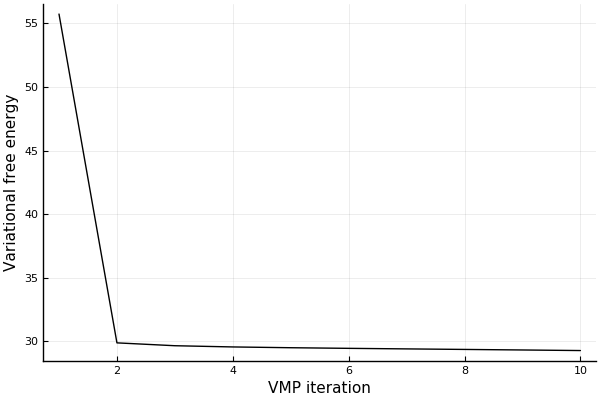

In [5]:
# Plot free energy to check for convergence
plot(1:num_iterations, F, color="black", label="")
xlabel!("VMP iteration")
ylabel!("Variational free energy")

Visualize the results.

In [12]:
include("scripts/ppl-2.jl")

# Estimated means
μ1_estimated = mean(marginals[:m_1])
μ2_estimated = mean(marginals[:m_2])

# Plot data and overlay estimated posterior probabilities
plot_posteriors(X, μ1_estimated, μ2_estimated)

MethodError: MethodError: no method matching MvNormal(::Float64, ::Float64)
Closest candidates are:
  MvNormal(!Matched::Tracker.TrackedArray{#s58,1,A} where A where #s58<:Real, ::Real) at /home/wmkouw/.julia/packages/DistributionsAD/7Met8/src/multivariate.jl:91
  MvNormal(!Matched::AbstractArray{#s171,1} where #s171<:Real, ::Real) at /home/wmkouw/.julia/packages/Distributions/2i7UF/src/multivariate/mvnormal.jl:207
  MvNormal(!Matched::Int64, ::Real) at /home/wmkouw/.julia/packages/Distributions/2i7UF/src/multivariate/mvnormal.jl:220

In [7]:
l = @layout [a; b; c]

# Plot data
p2 = scatter(X[:, 1], X[:, 2], color="blue", linewidth=2)

# Plot estimated distribution
x_test = range(-4, stop=4, length=200)
d1_est = Normal(mean(marginals[:m_1]), sqrt(var(marginals[:m_1])))
d2_est = Normal(mean(marginals[:m_2]), sqrt(var(marginals[:m_2])))
pi_est = mean(marginals[:_pi])
gmm_pdf = pi_est * pdf.(Ref(d1_est), x_test) + (1-pi_est) * pdf.(Ref(d2_est), x_test)
p3 = plot(x_test, gmm_pdf, color="black", xlims=[-4,4])
xlabel!("X")
ylabel!("p(X|θ)")

# Combined plot
plot(p1, p2, p3, layout = l)

UndefVarError: UndefVarError: p1 not defined

### A real-world problem

Let's have another look at the Old Faithful data set. Can we model it using our PPL's?

In [8]:
using DataFrames
using CSV
using LinearAlgebra

# Read file
old_faithful = CSV.read("datasets/old_faithful.csv")

# Convert file to matrix
X = convert(Matrix{Float64}, [old_faithful[1] old_faithful[2]])

# Center the data
X = X .- mean(X, dims=1)

# Normalize by standard deviation
X = X ./ std(X, dims=1)

# Scatter data points
scatter(X[:,1], X[:,2], legend=false, title="Old Faithful")

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[8]:7
└ @ Core In[8]:7
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[8]:7
└ @ Core In[8]:7


UndefVarError: UndefVarError: std not defined

First of all, we should specify the model that we believe generated the data. 

In [9]:
# Set priors
m1 = [-1, -1]
m2 = [+1, +1]

# Call another instance of the model for this data set
gmm_model = GaussianMixtureModel(X', m1, m2);

# Construct Gibbs sampler
gmm_sampler = Gibbs(PG(100, :k), HMC(0.05, 10, :μ1, :μ2))

# Start sampling
tchain = mapreduce(c -> sample(gmm_model, gmm_sampler, 100), chainscat, 1);

UndefVarError: UndefVarError: GaussianMixtureModel not defined

As you may start to realize, sampling is slow.

In [10]:
# Means of distributions
μ1_estimated = vec(convert(Array{Float64,2}, mean(tchain[:μ1].value.data[:,:,1]; dims=1)));
μ2_estimated = vec(convert(Array{Float64,2}, mean(tchain[:μ2].value.data[:,:,1]; dims=1)));

# Report estimated mean for each cluster
println("μ1_estimated = "*string(μ1_estimated))
println("μ2_estimated = "*string(μ2_estimated))

UndefVarError: UndefVarError: tchain not defined

In [11]:
# Plot iso-probability lines
x1 = range(-3, stop = 3)
x2 = range(-3, stop = 3)

# Scatter points
scatter(X[:, 1], X[:,2], legend=false, title="Fit of model on Old Faithful")
contour!(x1, x2, (x, y) -> predict(x, y, [0.5, 0.5], μ1_estimated, μ2_estimated))

MethodError: MethodError: no method matching MvNormal(::Float64, ::Float64)
Closest candidates are:
  MvNormal(!Matched::Tracker.TrackedArray{#s58,1,A} where A where #s58<:Real, ::Real) at /home/wmkouw/.julia/packages/DistributionsAD/7Met8/src/multivariate.jl:91
  MvNormal(!Matched::AbstractArray{#s171,1} where #s171<:Real, ::Real) at /home/wmkouw/.julia/packages/Distributions/2i7UF/src/multivariate/mvnormal.jl:207
  MvNormal(!Matched::Int64, ::Real) at /home/wmkouw/.julia/packages/Distributions/2i7UF/src/multivariate/mvnormal.jl:220